In [9]:
#Add needed imports
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, recall_score,f1_score
from sklearn.tree import DecisionTreeClassifier  
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn import svm

import os
#Read data
proccessed_data_path =os.path.join(os.path.pardir,os.path.pardir,'data','processed')
train_path = os.path.join(proccessed_data_path,'dataset8.csv')
df = pd.read_csv(train_path)
labels=df['Churn']
x = df.drop(columns=['Churn','Unnamed: 0'],axis = 'columns')
y=np.ravel(labels)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)
oversample = SMOTENC(categorical_features=[1,2,17,18,19])
x_train, y_train = oversample.fit_resample(x_train, y_train)

sc = RobustScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [10]:
svm_model = svm.SVC(random_state=0,gamma='auto')
rf_model=RandomForestClassifier(random_state=0)
dt_model=DecisionTreeClassifier(random_state=0,criterion='entropy',max_depth = 7,min_samples_leaf=30) 
lr_model= LogisticRegression(random_state=0, max_iter=300)
mlp_model =MLPClassifier(random_state=0,activation='relu', solver='sgd',learning_rate='adaptive')
xgb_model = XGBClassifier(random_state=0 ,learning_rate=0.05, max_depth=7,eval_metric='mlogloss',use_label_encoder =False)
gmb_model= GradientBoostingClassifier(random_state=0,n_estimators=20,learning_rate=0.75,max_features=4,max_depth=5)

model_params = {
    'svm': {
        'model': svm_model,
        'params' : {
            'C': [15,10],
            'kernel': ['rbf','linear']
        }  
     },
    'rf': {
        'model': rf_model,
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
     'dt': {
        'model': dt_model,
        'params' : {}
    },
    'lr' : {
        'model':lr_model,
        'params': {
            'C': [1,5,10]
        }
    },
    'mlp' : {
        'model':mlp_model,
        'params': {}
    },
    'xg_boost' : {
        'model':xgb_model,
        'params': {}
    },
    'gbm' : {
        'model':gmb_model,
        'params': {}
    }
}

In [14]:
scores = []
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=100)
for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=cv, return_train_score=False)
    clf.fit(x_train,y_train)
    conf_matrix =confusion_matrix(y_test,clf.predict(x_test))
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'precision':precision_score(y_test,clf.predict(x_test)),
        'recall':recall_score(y_test,clf.predict(x_test)),
        'f1_score':f1_score(y_test,clf.predict(x_test)),
        'true positives':conf_matrix[0][0],
        'true negatives':conf_matrix[1][1],
        'false postives':conf_matrix[0][1],
        'false negatives':conf_matrix[1][0]
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','precision','recall','f1_score','true positives','true negatives','false postives','false negatives','best_params'])
print(df)

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer

      model  best_score  precision    recall  f1_score  true positives  \
0       svm    0.918931   0.604317  0.595745  0.600000             704   
1        rf    0.919302   0.661290  0.581560  0.618868             717   
2        dt    0.794876   0.779412  0.751773  0.765343             729   
3        lr    0.763446   0.352941  0.680851  0.464891             583   
4       mlp    0.840079   0.535519  0.695035  0.604938             674   
5  xg_boost    0.922812   0.755396  0.744681  0.750000             725   
6       gbm    0.903959   0.608974  0.673759  0.639731             698   

   true negatives  false postives  false negatives                 best_params  
0              84              55               57  {'C': 15, 'kernel': 'rbf'}  
1              82              42               59        {'n_estimators': 10}  
2             106              30               35                          {}  
3              96             176               45                   {'C': 10}  
4 

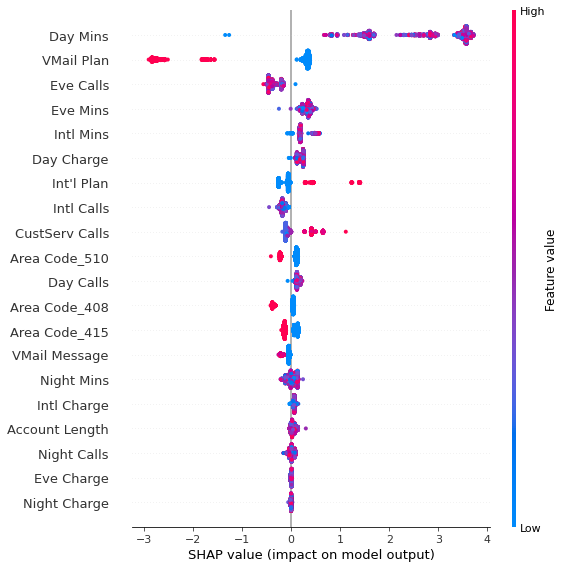

In [13]:
import shap
xgb_model = XGBClassifier(random_state=0 ,learning_rate=0.05, max_depth=7,eval_metric='mlogloss',use_label_encoder =False)
xgb_model.fit(x_train,y_train)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(x)
shap.summary_plot(shap_values, x)